<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Final <code> Exercise</code>:</b> We will build an LLM Agentic Workflow with Langchain that has a Router, Skills, Memory and States. In additon, we evaluate the model using LLM as a Judge. Download the wragby.json file with the notebookUse the Llama API provided and set like this in your colab or notebook <code>LLAMA_API_KEY='your_api_key_here'</code></p>

In [1]:
# Load environment variables
import os
from dotenv import load_dotenv
_ = load_dotenv()

In [2]:
### LLMs
# Define the base URL
BASE_URL = "https://api.llama.com/v1"

In [3]:
#Read files
import json
# Open and read the JSON file
with open('wragby.json', 'r') as file:
    data = json.load(file)

# print(data)
# Docs to index
urls = data["urls"]

In [4]:
### Build Index

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorstore
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=HuggingFaceEmbeddings(),
)
retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.
/var/tmp/ipykernel_12820/1725153631.py:22: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding=HuggingFaceEmbeddings(),
/var/tmp/ipykernel_12820/1725153631.py:22: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  embedding=HuggingFaceEmbeddings(),


In [5]:
# Take a peek at the document
# docs

In [6]:
import json
import requests
from typing import Literal
from pydantic import BaseModel, Field

# Configuration
LLAMA_API_KEY = os.environ['LLAMA_API_KEY']

# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""
    
    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

def chat_completion(messages, model="Llama-4-Scout-17B-16E-Instruct-FP8", max_tokens=1024):
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {LLAMA_API_KEY}",
    }
    payload = {
        "messages": messages,
        "model": model,
        "max_tokens": max_tokens,
        "stream": False,
    }
    response = requests.post("https://api.llama.com/v1/chat/completions", headers=headers, json=payload)
    return response

def route_query(question: str) -> RouteQuery:
    """Route a user question using Llama API with structured output."""
    
    # System prompt
    system_message = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to the business Wragby Solutions, their product information, and customer sales.
Use the vectorstore for questions on these topics. Otherwise, use web-search.

You must respond with a JSON object in this exact format:
{"datasource": "vectorstore"} or {"datasource": "web_search"}

Only respond with the JSON object, no additional text."""

    # Prepare messages
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": question}
    ]
    
    # Get response from Llama API
    response = chat_completion(messages, max_tokens=50)
    print(response)
    # return response.json()
    
    try:
        # Extract the response content
        content = response.json()['completion_message']['content']['text'].strip()
        print("content", content)
        
        # Parse JSON response
        route_data = json.loads(content)
        print("route_data", route_data)
        
        # Validate and return RouteQuery object
        return RouteQuery(**route_data)
    
    except (KeyError, json.JSONDecodeError, ValueError) as e:
        print(f"Error parsing response: {e}")
        print(f"Raw response: {response}")
        # Default fallback
        return RouteQuery(datasource="web_search")

In [7]:
question1 = "Who is the current President of Nigeria?"
question2 = "What are the types of solutions offered by Wbizmanager?"
    
print("Question 1:", question1)
result1 = route_query(question1)
# print(result1)
print()
print("Route:", result1)
print()

Question 1: Who is the current President of Nigeria?
<Response [200]>
content {"datasource": "web_search"}
route_data {'datasource': 'web_search'}

Route: datasource='web_search'



In [8]:
print("Question 2:", question2)
result2 = route_query(question2)
print()
print("Route:", result2)
print()

Question 2: What are the types of solutions offered by Wbizmanager?
<Response [200]>
content {"datasource": "vectorstore"}
route_data {'datasource': 'vectorstore'}

Route: datasource='vectorstore'



In [9]:
#Generate
# Post-processing function to format documents
# Remove the duplicate function definition and use this single, robust version
def format_docs(docs):
    """Format a list of documents into a single string."""
    
    if not docs:
        return ""
    
    formatted_docs = []
    
    for doc in docs:
        try:
            # Try to access page_content attribute (LangChain document format)
            if hasattr(doc, 'page_content'):
                formatted_docs.append(doc.page_content)
            # Try to access 'content' key (dictionary format)
            elif isinstance(doc, dict) and 'content' in doc:
                formatted_docs.append(doc['content'])
            # Try to access 'page_content' key (dictionary format)
            elif isinstance(doc, dict) and 'page_content' in doc:
                formatted_docs.append(doc['page_content'])
            # If it's just a string
            elif isinstance(doc, str):
                formatted_docs.append(doc)
            else:
                # Convert to string as fallback
                formatted_docs.append(str(doc))
        except Exception as e:
            print(f"Error processing document: {e}")
            # Add as string fallback
            formatted_docs.append(str(doc))
    
    return "\n\n".join(formatted_docs)
        

def rag_generate_answer(question: str, docs: list) -> str:
    """Generate an answer using RAG (Retrieval-Augmented Generation)."""
    
    # RAG prompt template (equivalent to rlm/rag-prompt from LangChain hub)
    system_message = """You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the question. 
    If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise."""
    
    # Format the context from retrieved documents
    context = format_docs(docs)
    
    # Create the user message with context and question
    user_message = f"""Context: {context}

    Question: {question}

    Answer:"""
    
    # Prepare messages for API
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_message}
    ]
    
    try:
        # Get response from Llama API
        response = chat_completion(messages, max_tokens=512)
        
        # Extract and return the generated answer
        answer = response.json()['completion_message']['content']['text'].strip()
        return answer
    
    except Exception as e:
        print(f"Error generating RAG answer: {e}")
        return "I apologize, but I encountered an error while generating an answer."

In [10]:
# Example usage (assuming you have 'docs' and 'question' variables)
# Replace with your actual question and retrieved documents
question = "What are the types of SAP Solutions available?"
# question = "Who is the President of Belarus?"
docs = retriever.get_relevant_documents(question)
# print(f"Retrieved Document: {doc_txt}")
print()


# Generate answer using RAG
generation = rag_generate_answer(question, docs)
print("Question:", question)
print("Generated Answer:", generation)

/var/tmp/ipykernel_12820/4002427605.py:5: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)



Question: What are the types of SAP Solutions available?
Generated Answer: Based on the context provided, Wragby Business Solutions and Technologies Limited offers SAP solutions, including SAP Business One and SAP Concur. 

They also provide services related to SAP, as evident from the SAP Africa Partner Awards. 

However, I don't have an exhaustive list of SAP solutions offered by them.


In [11]:
### Answer Grader 
def grade_answer_quality(question: str, generation: str) -> dict:
    """Grade whether an LLM generation addresses/resolves the user question."""
    
    # System prompt for answer grading
    system_message = """You are a grader assessing whether an answer addresses / resolves a question.
Give a binary score 'yes' or 'no'. 'Yes' means that the answer resolves the question.

You must respond with exactly one word:
- yes (if the answer addresses and resolves the question)
- no (if the answer does not address or resolve the question)

Only respond with 'yes' or 'no', no additional text or explanation."""

    # Format the user message with question and generation
    user_message = f"User question: \n\n {question} \n\n LLM generation: {generation}"
    
    # Prepare messages for API
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_message}
    ]
    
    try:
        # Get response from Llama API
        response = chat_completion(messages, max_tokens=10)
        
        # Extract the response content
        content = response.json()['completion_message']['content']['text'].strip().lower()
        print(content)
        
        # Validate response
        if "yes" in content:
            score = "yes"
        elif "no" in content:
            score = "no"
        else:
            # Default to 'no' for unclear responses
            print(f"Unclear answer grading response: {content}, defaulting to 'no'")
            score = "no"
            
        return {"score": score}
    
    except Exception as e:
        print(f"Error calling Llama API for answer grading: {e}")
        # Default to 'no' on error
        return {"score": "no"}

In [12]:
# Test the answer grader with existing question and generation
result = grade_answer_quality(question, generation)
print(f"Question: {question}")
print(f"Generation: {generation[:100]}...")
print(f"Answer quality score: {result}")

no
Question: What are the types of SAP Solutions available?
Generation: Based on the context provided, Wragby Business Solutions and Technologies Limited offers SAP solutio...
Answer quality score: {'score': 'no'}


In [13]:
### Hallucination Grader 

def grade_hallucinations(documents: list, generation: str) -> dict:
    """Grade whether an LLM generation is grounded in the provided documents."""
    
    # System prompt for hallucination grading
    system_message = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts.
Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts.

You must respond with exactly one word:
- yes (if the generation is grounded in the facts)
- no (if the generation contains hallucinations or unsupported claims)

Only respond with 'yes' or 'no', no additional text or explanation."""

    # Format documents into a single string
    if isinstance(documents, list):
        # If documents is a list of document objects with page_content
        if hasattr(documents[0], 'page_content'):
            docs_text = format_docs(documents)
        else:
            # If documents is a list of strings
            docs_text = "\n\n".join(documents)
    else:
        # If documents is already a string
        docs_text = str(documents)
    
    # Format the user message with documents and generation
    user_message = f"Set of facts: \n\n {docs_text} \n\n LLM generation: {generation}"
    
    # Prepare messages for API
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_message}
    ]
    
    try:
        # Get response from Llama API
        response = chat_completion(messages, max_tokens=10)
        
        # Extract the response content
        content = response.json()['completion_message']['content']['text'].strip().lower()
        
        # Validate response
        if "yes" in content:
            score = "yes"
        elif "no" in content:
            score = "no"
        else:
            # Default to 'no' for unclear responses (conservative approach)
            print(f"Unclear hallucination grading response: {content}, defaulting to 'no'")
            score = "no"
            
        return {"score": score}
    
    except Exception as e:
        print(f"Error calling Llama API for hallucination grading: {e}")
        # Default to 'no' on error (conservative approach - assume hallucination)
        return {"score": "no"}

In [14]:
### Retrieval Grader 

def grade_document_relevance(question: str, document: str) -> dict:
    """Grade the relevance of a retrieved document to a user question."""
    
    # System prompt for document grading
    system_message = """You are a grader assessing relevance of a retrieved document to a user question.
If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant.
It does not need to be a stringent test. The goal is to filter out erroneous retrievals.
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.

You must respond with exactly one word:
- yes (if document is relevant)
- no (if document is not relevant)

Only respond with 'yes' or 'no', no additional text or explanation."""

    # Format the user message with document and question
    user_message = f"Retrieved document: \n\n {document} \n\n User question: {question}"
    # print(user_message)
    
    # Prepare messages for API
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_message}
    ]
    
    try:
        # Get response from Llama API
        response = chat_completion(messages)
        # print("response", response.json())
        
        # Extract the response content
        content = response.json()['completion_message']['content']['text'].strip().lower()
        
        # Validate response
        if "yes" in content:
            score = "yes"
        elif "no" in content:
            score = "no"
        else:
            # Default to 'no' for unclear responses
            print(f"Unclear grading response: {content}, defaulting to 'no'")
            score = "no"
            
        return {"score": score}
    
    except Exception as e:
        print(f"Error calling Llama API for document grading: {e}")
        # Default to 'no' on error (conservative approach)
        return {"score": "no"}

In [15]:
### Web Search

from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

In [16]:
from typing_extensions import TypedDict
from typing import List

### State

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents 
    """
    question : str
    generation : str
    web_search : str
    documents : List[str]

from langchain.schema import Document

### Nodes

def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    print("documents", documents)
    return {"documents": documents, "question": question}

def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    
    # RAG generation
    generation = rag_generate_answer(documents, question)
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = grade_document_relevance(question, d.page_content)
        # print("score", score)
        grade = score["score"]
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}
    
def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    print("docs-----", docs)
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents, "question": question}

### Conditional edge

def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = route_query(question)  
    print("source", source)
    if source.datasource == 'web_search':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source.datasource == 'vectorstore':
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = grade_hallucinations(documents,  generation)
    grade = score["score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = grade_answer_quality(question,generation)
        grade = score["score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [17]:
from langgraph.graph import END, StateGraph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search) # web search
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) # generate

In [18]:
# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)

workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
    },
)

In [19]:
app = workflow.compile().with_config({"run_name": "Wragby Solutions Assistant"})

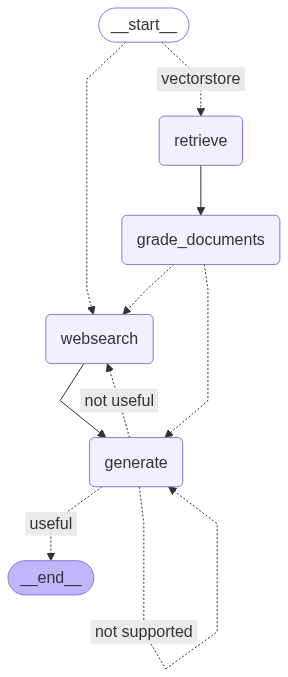

In [22]:
from IPython.display import Image, display

# Assuming you have already created and compiled your graph as 'app'
png_graph = app.get_graph().draw_mermaid_png()
display(Image(png_graph))

In [21]:
# Test
from pprint import pprint
inputs = {"question": "How can SMBs use Wbizmanager"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---ROUTE QUESTION---
<Response [200]>
content {"datasource": "vectorstore"}
route_data {'datasource': 'vectorstore'}
source datasource='vectorstore'
---ROUTE QUESTION TO RAG---
---RETRIEVE---
documents [Document(metadata={'language': 'en-US', 'description': 'Wragby Business Solutions & Technologies Limited, a leading indigenous technology company, has delivered record-breaking services revenue growth by 450%', 'title': 'Cloud Service Adoption: Wragby Records 450% Revenue Growth in 2021 - Wragby Business Solutions and Technologies Limited', 'source': 'https://www.wragbysolutions.com/cloud-service-adoption-wragby-records-450-revenue-growth-in-2021/'}, page_content='follow usFb\nLn\nTw\nYt \n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n \n\n\nPlot 21A Olubunmi Rotimi Street, Lekki 1, Lagos Nigeria\ninfo@wragbysolutions.com\nPhone: +2342017006320\nFb\nLn\nTw\nYt'), Document(metadata={'title': 'Strategizing for success - Wragby Business Solutions and Technologies Limited', 'language': 'en-US', 'descr